References:
1. https://ieeexplore-ieee-org.libproxy1.nus.edu.sg/document/10030009
2. https://www.academia.edu/102075121/Feature_Expansion_Word2Vec_for_Sentiment_Analysis_of_Public_Policy_in_Twitter
3. https://www.researchgate.net/publication/362102941_Sentiment_Analysis_using_NLP_and_Machine_Learning_Techniques_on_Social_Media_Data

Paper in link 1 only explores Word2Vec in relation to Naive Bayes. According to our reserach, Bahrawi (2019) and others suggest that the exploration of additional machine learning algorithms paired with various vectorization to to identify optimal combinations further sentiment analysis accuracy, which we have done so in this code.

Secondly, our paper aims to see whether these combinations only work on context-specific data sets like our references have explored or do different combinations do better on different themes of datasets (for eg. the Logistics Regression with Bag-of-Words vectorization could do better for movie-specific datasets as explored in Part 1/ our first code whereas the Naive Bayes with TF-IDF vectorization could work better on general mix of social media sentiments and movie-specific sentiments that we explore in this code). This overcomes the limitation of classification models being only more appropriate for specific types of data on social media or movie reviews separately and hopes to identify a model with more general usability on data with unsorted themes/domains.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions
!pip install nltk
# Standard library imports
import string
import re
import contractions
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import seaborn as sns
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from wordcloud import WordCloud, STOPWORDS
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Importing our own new data

In [ ]:
temp_df1 = pd.read_csv('/content/drive/My Drive/filteredtweets.csv', header = None)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/filteredtweets.csv'

In [ ]:
#To keep a copy of the original dataset labelled as temp_df1 before cleaning
temp_uncleaned_df1 = temp_df1

Exploring the Dataset

In [ ]:
num_rows = len(temp_uncleaned_df1)
print("Number of rows:", num_rows)

Number of rows: 9728


In [ ]:
# Display the original DataFrame
print("Original DataFrame:")
print(temp_uncleaned_df1)

# Swap columns 0 and 1
temp_uncleaned_df1.iloc[:, [0, 1]] = temp_uncleaned_df1.iloc[:, [1, 0]]

# Display the DataFrame after swapping columns
print("\nDataFrame after swapping columns 0 and 1:")
print(temp_uncleaned_df1)


Original DataFrame:


NameError: name 'temp_uncleaned_df1' is not defined

In [ ]:
num_rows = len(temp_uncleaned_df1)
print("Number of rows:", num_rows)

Number of rows: 9728


In [ ]:
temp_uncleaned_df1.head()

,0,1
0,res,tweets
1,1,I made a fanmix in the course of the overnight...
2,1,"@TheRockStarMama Okay, now what happens? Is i..."
3,1,"going shopping for Conner's bday stuff today, ..."
4,1,thanx @thisisLF and @eye_an!!! Hope u guys can...


In [ ]:
# Remove the first row (which contains the original headers)
temp_uncleaned_df1 = temp_df1.iloc[1:, ]

# Reset the index after removing the first row
temp_uncleaned_df1.reset_index(drop=True, inplace=True)

In [ ]:
temp_uncleaned_df1.head()

,0,1
0,1,I made a fanmix in the course of the overnight...
1,1,"@TheRockStarMama Okay, now what happens? Is i..."
2,1,"going shopping for Conner's bday stuff today, ..."
3,1,thanx @thisisLF and @eye_an!!! Hope u guys can...
4,1,@davidschwimmer- would totally love a shout ou...


Cleaning the Data (with Cleaning methods specific to Tweets)

In [ ]:
#Remove Emojis

def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

temp_uncleaned_df1[1] = temp_uncleaned_df1[1].apply(lambda z: remove_emoji(z))

<ipython-input-11-a0ba79703242>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_uncleaned_df1[1] = temp_uncleaned_df1[1].apply(lambda z: remove_emoji(z))


In [ ]:
#Remove @

def remove_user(tweet):
    if '@' not in tweet:
        return tweet
    sep=tweet.split(' ')
    for i in sep:
        if '@' in i:
            sep.remove(i)
    tweet=' '.join(sep)
    return tweet

temp_uncleaned_df1[1] = temp_uncleaned_df1[1].apply(lambda z: remove_user(z))

<ipython-input-12-999ca00d8dfa>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_uncleaned_df1[1] = temp_uncleaned_df1[1].apply(lambda z: remove_user(z))


In [ ]:
temp_uncleaned_df1.head()

,0,1
0,1,I made a fanmix in the course of the overnight...
1,1,"Okay, now what happens? Is it even possible t..."
2,1,"going shopping for Conner's bday stuff today, ..."
3,1,thanx and Hope u guys can make it out on Friday
4,1,would totally love a shout out as well....Plz...


Importing original dataset provided in IT1244

In [ ]:
temp_df2 = pd.read_csv('/content/drive/My Drive/dataset.csv', header = None)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/dataset.csv'

In [ ]:
temp_df2.head()

,0,1
0,1,the rock is destined to be the 21st century's ...
1,1,"the gorgeously elaborate continuation of "" the..."
2,1,effective but too-tepid biopic
3,1,if you sometimes like to go to the movies to h...
4,1,"emerges as something rare , an issue movie tha..."


Concatenating our own new data to original IT1244 dataset to create a new larger and more varied dataset

(From this point on, all "Data" refers to this newly concatenated dataset, df)

In [ ]:
df = pd.concat([temp_uncleaned_df1, temp_df2], ignore_index=True)

# Ignore_index=True ensures that the resulting DataFrame has a new index without preserving the original indices of df1 and df2

In [ ]:
#To keep a copy of original dataset before cleaning as df
uncleaned_df = df

In [ ]:
uncleaned_df.head()

,0,1
0,1,I made a fanmix in the course of the overnight...
1,1,"Okay, now what happens? Is it even possible t..."
2,1,"going shopping for Conner's bday stuff today, ..."
3,1,thanx and Hope u guys can make it out on Friday
4,1,would totally love a shout out as well....Plz...


Label Encoder

In [ ]:
y = y.astype(str)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X = X.astype(str)

label_encoder = LabelEncoder()
X_encoded = label_encoder.fit_transform(X)

Processing the Data

In [ ]:
#Define new headers
new_headers= ["values", "sentences"]

In [ ]:
#Add headers to the dataset
uncleaned_df.columns = new_headers

In [ ]:
#Calling on the dataset with headers
uncleaned_df.head()

,values,sentences
0,1,I made a fanmix in the course of the overnight...
1,1,"Okay, now what happens? Is it even possible t..."
2,1,"going shopping for Conner's bday stuff today, ..."
3,1,thanx and Hope u guys can make it out on Friday
4,1,would totally love a shout out as well....Plz...


Cleaning the Data with common NLP Text Cleaning Methods

In [ ]:
# Handling Missing Values
# Identify missing values
missing_values = uncleaned_df.isnull().sum()

In [ ]:
# Drop rows with missing values
uncleaned_df.dropna(inplace=True)

# Fill missing values with a specific value
uncleaned_df.fillna(0, inplace=True)

# Handling Duplicates
# Check for duplicate rows
duplicates = uncleaned_df.duplicated().sum()

In [ ]:
# Remove duplicate rows
uncleaned_df.drop_duplicates(inplace=True)

In [ ]:
# Changing all uppercase to lowercase
uncleaned_df['sentences'] = uncleaned_df['sentences'].apply(lambda x: x.lower())

In [ ]:
# Removing all punctuation
def remove_punctuation(text):
    return "".join([char for char in text if char not in string.punctuation])
uncleaned_df['sentences']=uncleaned_df['sentences'].apply(remove_punctuation)

In [ ]:
# Changing all contractions to uncontracted words eg. can't to cannot
uncleaned_df['sentences']= uncleaned_df['sentences'].apply(contractions.fix)

In [ ]:
# Data has been cleaned, now we make a copy of it in a variable cleaned dataframe as cleaned_df
cleaned_df = uncleaned_df

In [ ]:
cleaned_df.head()

,values,sentences
0,1,i made a fanmix in the course of the overnight...
1,1,okay now what happens is it even possible to ...
2,1,going shopping for conners birthday stuff toda...
3,1,thanx and hope you guys can make it out on fri...
4,1,would totally love a shout out as wellplz


In [ ]:
# To keep the set of data before changing the texts to clear stopwords and lematize the texts
unchanged_cleaned_df = cleaned_df

Tokenization

In [ ]:
def sentiment_tokenizer(text):

    # Tokenize the text using NLTK's word_tokenize function
    tokens = word_tokenize(text)
    return tokens

# Apply the sentiment tokenizer to the "Cleaned_Text" column
cleaned_df['sentences'] = cleaned_df['sentences'].apply(sentiment_tokenizer)

In [ ]:
# List of stopwords that nltk considers to be of little value for natural language processing task as they occur frequently but typically do not carry significant meaning
stop_words = set(stopwords.words('english'))

In [ ]:
print(stop_words)

{'himself', 't', 'your', 'into', 'hers', 'nor', "isn't", 'further', 'each', 'its', 'between', 'if', 'then', 'couldn', 'is', 'once', 'there', 've', 'he', 'for', 'myself', 's', 'was', 'me', 'have', 'below', 'up', "shan't", 'our', 'than', 'through', 'after', 'wasn', 'she', 'against', 'why', 'should', 'didn', 'an', 'about', 'itself', 'so', 'm', 'y', 'shan', 'not', 'to', 'theirs', 'hadn', 'who', 'here', 'but', 'isn', "mustn't", 'above', 'hasn', "hasn't", 'haven', 'over', 'at', 'ours', 'same', "hadn't", 'or', 'both', 'ourselves', 'those', 'mustn', 'can', "wouldn't", 'where', 'what', 'that', 'has', 'yourselves', 'being', 'we', 'as', "won't", 'no', 'this', 'having', 'i', "you've", 'on', 'you', 'are', 'more', "mightn't", 'before', 'doing', 'the', 'when', 'which', 'weren', 'don', 'very', 'other', 'them', 'of', 'shouldn', 'how', 'any', 'again', "doesn't", 'themselves', 'down', 'own', 'by', 'such', 'now', 'and', "weren't", 'because', 'most', 'few', 'will', 'him', 'ain', 'only', "it's", 'my', 'out'

In [ ]:
# Keep these words in the text from stop_words as they could correlate to sentiment and could be important for sentiment analysis

keep_in_tokens = ["no", "not", "on", "off", "too", "out", "over", "under"]

removed_words = []

for word in keep_in_tokens:
    if word in stop_words:
        stop_words.remove(word)
        removed_words.append(word)

print("Words removed:", removed_words)

#Removing our set of defined stop words from our data

def filter_tokens(tokens):
    return [token for token in tokens if token not in stop_words]

cleaned_df["sentences"] = cleaned_df["sentences"].apply(filter_tokens)

Words removed: ['no', 'not', 'on', 'off', 'too', 'out', 'over', 'under']


In [ ]:
cleaned_df.head()

,values,sentences
0,1,"[made, fanmix, course, overnight, never, made,..."
1,1,"[okay, happens, even, possible, eat, too, much..."
2,1,"[going, shopping, conners, birthday, stuff, to..."
3,1,"[thanx, hope, guys, make, out, on, friday]"
4,1,"[would, totally, love, shout, out, wellplz]"


Lemmatization

In [ ]:
# Text normalization technique used in NLP to reduce words to their base/ root form known as the lemma - makes it easier for the ML algorithm to compare and analyse words with similar meanings
# Joins back these root words into sentences as well for sentence analysis
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(filtered_tokens):
  return ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])

cleaned_df['sentences'] = cleaned_df['sentences'].apply(lemmatize_tokens)

In [ ]:
cleaned_df.head()

,values,sentences
0,1,made fanmix course overnight never made one fa...
1,1,okay happens even possible eat too much cheese
2,1,going shopping conners birthday stuff today fu...
3,1,thanx hope guy make out on friday
4,1,would totally love shout out wellplz


Data Visualization

In [ ]:
# Generates a wordcloud for data visualisation purposes - like mentimeter showing common words in our data
def generate_wcloud(sentences, stop):
    wordcloud = WordCloud(stopwords=stop, background_color='black')
    wordcloud.generate(sentences)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()


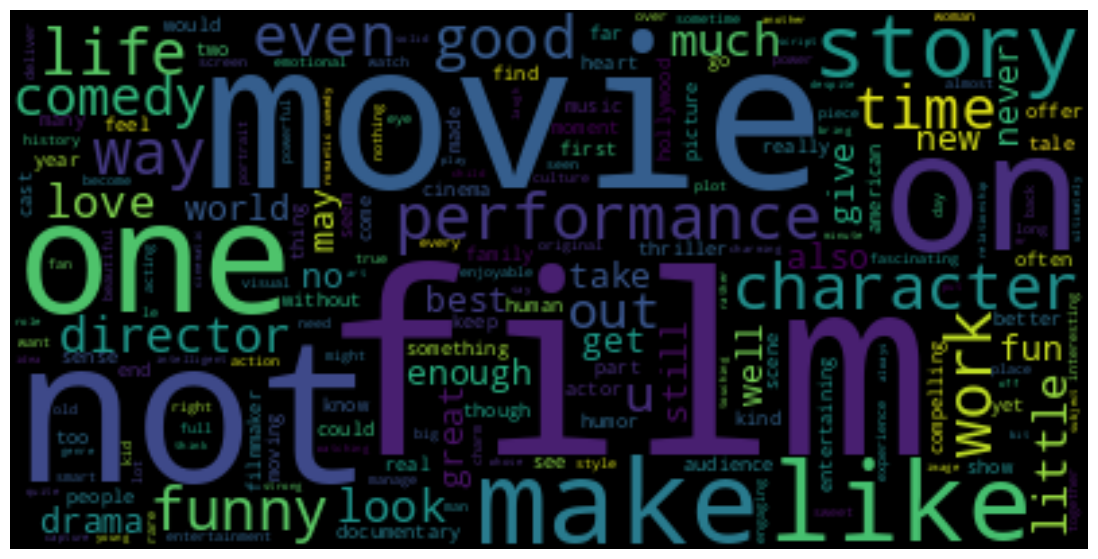

In [ ]:
#For positive sentiments
pos_text = cleaned_df.loc[cleaned_df['values'] == 1].sentences
sentences = " ".join(review for review in pos_text.astype(str))

generate_wcloud(sentences, stop_words)

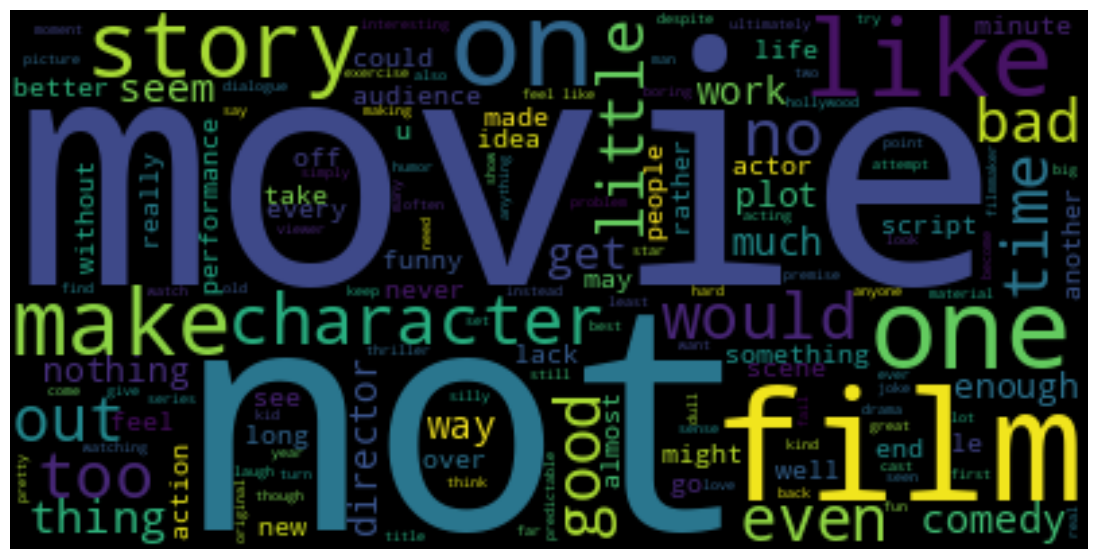

In [ ]:
#For negative sentiments
neg_text = cleaned_df.loc[cleaned_df['values'] == 0].sentences
sentences = " ".join(review for review in neg_text.astype(str))

generate_wcloud(sentences, stop_words)

In [ ]:
def plot_top_ngrams( text, range, top_n =10, plt_title = 'Top N-grams'):
  #Parameters: text: the text to analyse as a single string, range: a tuple(min_n, max_n) specifying the range of n-grams to consider, top_n: the number of top n-grams to display, plt_title: display title of the plot)
  vectorizer = CountVectorizer(ngram_range=range)
  X= vectorizer.fit_transform([text])
  ngram_vocab= vectorizer.get_feature_names_out()
  ngram_counts = X.toarray().flatten()
  ngram_dict = dict(zip(ngram_vocab, ngram_counts))
  top_ngrams = sorted(ngram_dict.items(), key=lambda x:x[1], reverse=True)[:top_n]
  ngram_words, ngram_counts = zip(*top_ngrams)

  #Plot the top n-grams
  plt.figure(figsize= (12,6))
  plt.barh(ngram_words, ngram_counts)
  plt.xlabel('Frequency')
  plt.ylabel('N-gram')
  plt.title(plt_title)
  plt.gca().invert_yaxis()
  plt.show

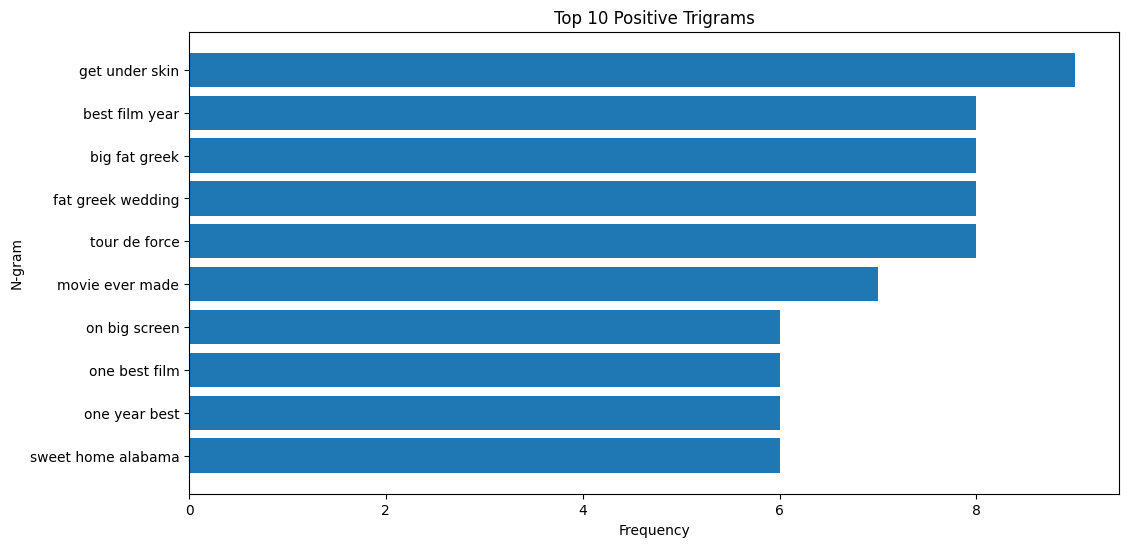

In [ ]:
range = (3,3)
pos_text = cleaned_df.loc[cleaned_df['values'] == 1].sentences
new_pos_text = " ".join(review for review in pos_text.astype(str))
plot_top_ngrams(new_pos_text, range, top_n = 10, plt_title= "Top 10 Positive Trigrams")

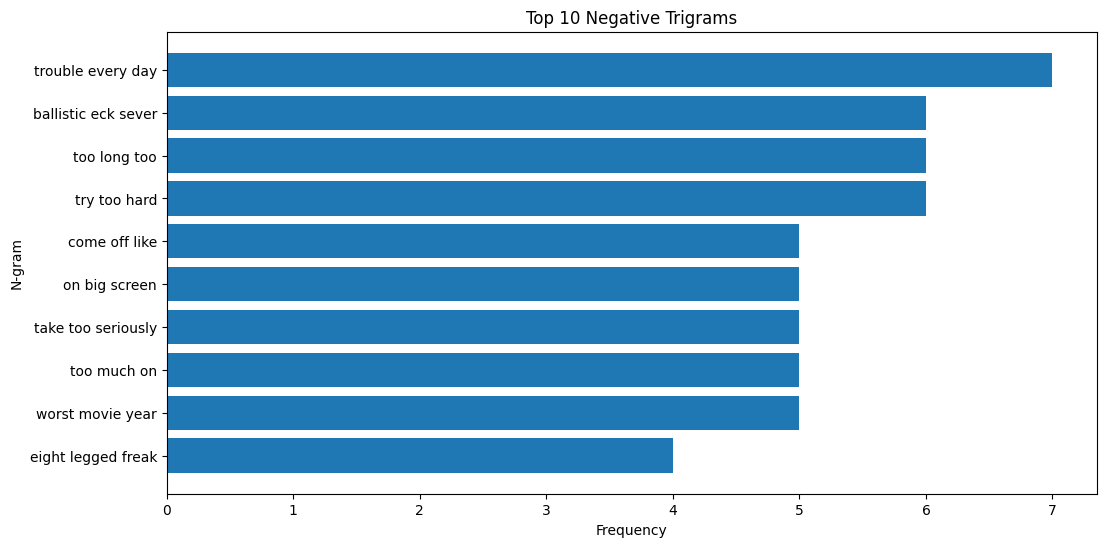

In [ ]:
range = (3,3)
neg_text = cleaned_df.loc[cleaned_df['values'] == 0].sentences
new_neg_text = " ".join(review for review in neg_text.astype(str))
plot_top_ngrams(new_neg_text, range, top_n = 10, plt_title= "Top 10 Negative Trigrams")

Train Test Split

In [ ]:
X = cleaned_df['sentences']
y = cleaned_df['values']

In [ ]:
X.shape

(20338,)

In [ ]:
y.shape

(20338,)

In [ ]:
#Generate Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16270,)
(16270,)
(4068,)
(4068,)


In [ ]:
train_split = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], ignore_index=True, axis=1)
train_split = train_split.rename(columns={0: 'sentences', 1: 'values'})

test_split = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], ignore_index=True, axis=1)
test_split = test_split.rename(columns={0: 'sentences', 1: 'values'})

In [ ]:
test_split.head()

,sentences,values
1161,happy birthday jenn glad part birthday celebra...,1
6408,really like hat stole form chris morbitzer kin...,0
18952,whatever movie sentimental hypocritical lesson...,0
14773,not believe santa claus probably also think se...,1
3135,morning great finally meet,1


In [ ]:
train_split.head()

,sentences,values
2589,many thanks recommendation web hosting sorted ...,1
20169,swim mediocrity sticking head breath fresh air,0
1211,girl da best,1
19187,not fan adventues steve terri avoid like dread...,0
19711,fascinating curiosity piece fascinating ten mi...,0


In [ ]:
train_split['values'].value_counts()

values
1    8649
0    7621
Name: count, dtype: int64

In [ ]:
test_split['values'].value_counts()

values
1    2163
0    1905
Name: count, dtype: int64

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16270,)
(16270,)
(4068,)
(4068,)


Exploring 3 Different Vectorizers

Creating a Bag-of-Words Vectorizer

In [ ]:
# CountVectorizer is an essential step in the process of converting text data into a numerical format suitable for machine learning algorithms
# Create a bag-of-words representation of the data
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(X_train)

# Transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

Creating a TF-IDF Vectorizer

In [ ]:
# TF-IDF stands for Term Frequency-Inverse Document Frequency is a numerical statistic used in NLP and text mining to reflect the importance of a word in a document relative to a collection of ducuments (corpus)
# Used for feature extraction and text vectorization in ML, in information retrival and text classification

# Create a term frequency representation of the data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

Creating a Word2Vec Vectorizer

In [ ]:
# Train Word2Vec model with our own data using Skipgram model
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Generate word embeddings
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key}

# Vectorize text data using word embeddings
def document_vectorizer(document):
    vectors = [word_embeddings[word] for word in document if word in word_embeddings]
    if vectors:
        return np.mean(vectors, axis=0)  # Use mean of word embeddings as document vector
    else:
        return np.zeros(word2vec_model.vector_size)  # Use zero vector if document has no known words

word2vec_X_train = np.array([document_vectorizer(doc) for doc in X_train])
word2vec_X_test = np.array([document_vectorizer(doc) for doc in X_test])

# Now, X_train_word2vec and X_test_word2vec contain the vectorized representations of our text data


Create a Standardised Function to train and evaluate a particular model

In [ ]:

def train_and_eval(model, trainX, trainY, testX, testY):

    # training the model
    fitted_model = model.fit(trainX, trainY)

    # getting and storing the predictions
    y_preds_train = fitted_model.predict(trainX)
    y_preds_test = fitted_model.predict(testX)

    # evaluating the model
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

Creating standarized functions for parameter tuning

In [ ]:
# Creating our own hyperparamter tuning function for Logistic Regression

def find_best_params_LR(C_values, X_train, y_train, X_test, y_test):
    # Initialize variables to store the best accuracy and corresponding parameters
    best_accuracy = 0
    best_params = {}

    # Loop over C_values
    for C in C_values:
        # Initialize Logistic Regression with current parameter
        log_reg = LogisticRegression(C=C, random_state=42)

        # Train the model
        log_reg.fit(X_train, y_train)

        # Predict on test set
        y_pred = log_reg.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Check if current accuracy is better than the best accuracy so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'C': C}

    return best_accuracy, best_params

In [ ]:
# Creating our own hyperparameter tuning function for Naive Bayes Classifier

def find_best_params_NB(alpha_values, X_train, y_train, X_test, y_test):
    # Define the parameter grid
    param_grid = {'alpha': alpha_values}

    # Initialize Multinomial Naive Bayes
    mnb = MultinomialNB()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(mnb, param_grid, cv=3, scoring='accuracy')

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_mnb = grid_search.best_estimator_

    # Predict on test set
    y_pred = best_mnb.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Return accuracy and best parameters
    return accuracy, best_mnb.get_params()

In [ ]:
# Creating our own hyperparamter tuning function for Random Forest Classifier

def find_best_params_RFC(trees, X_train, y_train, X_test, y_test):
    # Define the list of criterion
    criteria = ['gini', 'entropy']

    # Initialize variables to store the best accuracy and corresponding parameters
    best_accuracy = 0
    best_params = {}

    # Loop over trees and criterion
    for t in trees:
        for c in criteria:
            # Initialize RandomForestClassifier with current parameters
            RandFor = RandomForestClassifier(n_estimators=t, criterion=c, random_state=42)

            # Train the model
            RandFor.fit(X_train, y_train)

            # Predict on test set
            y_pred = RandFor.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Check if current accuracy is better than the best accuracy so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_estimators': t, 'criterion': c}

    return best_accuracy, best_params

Creating a function to generate a classification report to analyse results

In [ ]:
def generate_classification_report(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred)

    # Print the classification report
    print("Classification Report:")
    print(report)

Exploring 3 different machine learning algorithms - Logistic Regression, Naive Bayes Classifier and Random Forest Classifier

Logistic Regression with BoW Vectorizer

In [ ]:
C = [0.001, 0.01, 0.1, 1, 10, 500]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.6052243392747387
Test accuracy score : 0.5936578171091446

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.753841425937308
Test accuracy score : 0.7323008849557522

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.8635525507068224
Test accuracy score : 0.7984267453294002

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.9534111862323295
Test accuracy score : 0.80039331366765

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9918869084204056
Test accuracy score : 0.7900688298918387

 ----------------------------------------

LogisticRegression(C=500, max_iter=500)
Train accuracy score : 0.9989551321450523
Test accuracy score : 0.7576204523107178

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hyperparameter Tuning for Logistic Regression with BoW Vectoriser

In [ ]:
C_values = [ 0.01, 0.1, 1, 10, 100]
best_accuracy_LR_bow, best_params_LR_bow = find_best_params_LR(C_values, bow_X_train, y_train, bow_X_test, y_test)
print("Best Accuracy:", best_accuracy_LR_bow)
print("Best Parameters:", best_params_LR_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Accuracy: 0.80039331366765
Best Parameters: {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression with BoW Vectorizer

In [ ]:
best_model_LR_bow = LogisticRegression(**best_params_LR_bow, random_state=42)
generate_classification_report(best_model_LR_bow, bow_X_train, y_train, bow_X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1905
           1       0.81      0.82      0.81      2163

    accuracy                           0.80      4068
   macro avg       0.80      0.80      0.80      4068
weighted avg       0.80      0.80      0.80      4068



Naive Bayes Classifier with BoW Vectorizer

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1, 5, 10]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



MultinomialNB(alpha=0)
Train accuracy score : 0.9545175169022742
Test accuracy score : 0.7529498525073747

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9467117393976644
Test accuracy score : 0.7908062930186824

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9380454824830977
Test accuracy score : 0.8085054080629301

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9328826060233558
Test accuracy score : 0.8126843657817109

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9295636140135218
Test accuracy score : 0.8176007866273353

 ----------------------------------------

MultinomialNB(alpha=5)
Train accuracy score : 0.8889366933005531
Test accuracy score : 0.8176007866273353

 ----------------------------------------

MultinomialNB(alpha=10)
Train accuracy score : 0.8671788567916411
Test accuracy score : 0.808

Hyperparameter Tuning with Naive Bayes Classifier with BoW Vectorizer

In [ ]:
alpha_values = [0, 0.2, 0.6, 0.8, 1, 5 ]
best_accuracy_NB_bow, best_params_NB_bow = find_best_params_NB(alpha_values, bow_X_train, y_train, bow_X_test, y_test)
print("Accuracy:", best_accuracy_NB_bow)
print("Best Parameters:", best_params_NB_bow)



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Accuracy: 0.8176007866273353
Best Parameters: {'alpha': 5, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


Classification Report for Naive Bayes with BoW Vectorizer

In [ ]:
best_model_NB_bow = MultinomialNB(**best_params_NB_bow)
generate_classification_report(best_model_NB_bow, bow_X_train, y_train, bow_X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1905
           1       0.81      0.86      0.83      2163

    accuracy                           0.82      4068
   macro avg       0.82      0.81      0.82      4068
weighted avg       0.82      0.82      0.82      4068



Random Forest Classifier with BoW Vectorizer

In [ ]:
trees = [50,100,150,200,10,300]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


RandomForestClassifier(n_estimators=50)
Train accuracy score : 0.9998156115550092
Test accuracy score : 0.7777777777777778

 ----------------------------------------

RandomForestClassifier()
Train accuracy score : 0.9998770743700062
Test accuracy score : 0.7849065880039331

 ----------------------------------------

RandomForestClassifier(n_estimators=150)
Train accuracy score : 0.9998770743700062
Test accuracy score : 0.7876106194690266

 ----------------------------------------

RandomForestClassifier(n_estimators=200)
Train accuracy score : 0.9998770743700062
Test accuracy score : 0.7844149459193707

 ----------------------------------------

RandomForestClassifier(n_estimators=10)
Train accuracy score : 0.98740012292563
Test accuracy score : 0.761307767944936

 ----------------------------------------

RandomForestClassifier(n_estimators=300)
Train accuracy score : 0.9998770743700062
Test accuracy score : 0.7876106194690266

 ----------------------------------------


Hyperparameter Tuning for Random Forest Classifier with BoW Vectorizer

In [ ]:
trees = [10, 50, 100, 150, 200, 300]
best_accuracy_RFC_bow, best_params_RFC_bow = find_best_params_RFC(trees, bow_X_train, y_train, bow_X_test, y_test)
print("Best Accuracy:", best_accuracy_RFC_bow)
print("Best Parameters:", best_params_RFC_bow)

Best Accuracy: 0.7895771878072763
Best Parameters: {'n_estimators': 300, 'criterion': 'gini'}


Classification Report for Random Forest Classifier with BoW Vectorizer

In [ ]:
best_model_RFC_bow = RandomForestClassifier(**best_params_RFC_bow, random_state=42)
generate_classification_report(best_model_RFC_bow, bow_X_train, y_train, bow_X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1905
           1       0.78      0.83      0.81      2163

    accuracy                           0.79      4068
   macro avg       0.79      0.79      0.79      4068
weighted avg       0.79      0.79      0.79      4068



Logistic Regression with TFIDF Vectorizer

In [ ]:
C = [0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200, 500]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500)
Train accuracy score : 0.5315918869084204
Test accuracy score : 0.5317109144542773

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500)
Train accuracy score : 0.5811309157959434
Test accuracy score : 0.5821042281219272

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500)
Train accuracy score : 0.7901044867854948
Test accuracy score : 0.765732546705998

 ----------------------------------------

LogisticRegression(C=1, max_iter=500)
Train accuracy score : 0.8982790411800861
Test accuracy score : 0.8072763028515241

 ----------------------------------------

LogisticRegression(C=10, max_iter=500)
Train accuracy score : 0.9762138905961893
Test accuracy score : 0.8053097345132744

 ----------------------------------------

LogisticRegression(C=20, max_iter=500)
Train accuracy score : 0.9870928088506453
Test accuracy score : 0.7979351032448377

 ----------------------------------------


Hyperparameter Tuning for Logistic Regression with TF-IDF

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]
best_accuracy_LR_TFIDF, best_params_LR_TFIDF = find_best_params_LR(C_values, tfidf_X_train, y_train, tfidf_X_test, y_test)
print("Best Accuracy:", best_accuracy_LR_TFIDF)
print("Best Parameters:", best_params_LR_TFIDF)

Best Accuracy: 0.8072763028515241
Best Parameters: {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression with TF-IDF


In [ ]:
best_model_LR_TFIDF = LogisticRegression(**best_params_LR_TFIDF, random_state=42)
generate_classification_report(best_model_LR_TFIDF, tfidf_X_train, y_train, tfidf_X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1905
           1       0.81      0.83      0.82      2163

    accuracy                           0.81      4068
   macro avg       0.81      0.81      0.81      4068
weighted avg       0.81      0.81      0.81      4068



Naive Bayes Classifier with TFIDF Vectorizer

In [ ]:

alphas = [0, 0.2, 0.6, 0.8, 1, 5, 10]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



MultinomialNB(alpha=0)
Train accuracy score : 0.9597418561770129
Test accuracy score : 0.7441002949852508

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9496004917025199
Test accuracy score : 0.7920353982300885

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.9336816226183159
Test accuracy score : 0.8109636184857424

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9261831591886909
Test accuracy score : 0.816125860373648

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9199139520590043
Test accuracy score : 0.8168633235004916

 ----------------------------------------

MultinomialNB(alpha=5)
Train accuracy score : 0.8534111862323295
Test accuracy score : 0.7900688298918387

 ----------------------------------------

MultinomialNB(alpha=10)
Train accuracy score : 0.8103257529194837
Test accuracy score : 0.7642

Hyperparameter Tuning with Naive Bayes Classification with TF-IDF

In [ ]:
alpha_values = [0, 0.2, 0.6, 0.8, 1, 5]
best_accuracy_NB_TFIDF, best_params_NB_TFIDF = find_best_params_NB(alpha_values, tfidf_X_train, y_train, tfidf_X_test, y_test)
print("Accuracy:", best_accuracy_NB_TFIDF)
print("Best Parameters:", best_params_NB_TFIDF)

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

Accuracy: 0.8168633235004916
Best Parameters: {'alpha': 1, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


Classification Report for Naive Bayes Classification with TF-IDF

In [ ]:
best_model_NB_TFIDF= MultinomialNB(**best_params_NB_TFIDF)
generate_classification_report(best_model_NB_TFIDF, tfidf_X_train, y_train, tfidf_X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      1905
           1       0.80      0.88      0.84      2163

    accuracy                           0.82      4068
   macro avg       0.82      0.81      0.81      4068
weighted avg       0.82      0.82      0.82      4068



Random Forest Classifier with TFIDF Vectorizer

In [ ]:
trees = [10,50,100,150,200,300]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

NameError: name 'RandomForestClassifier' is not defined

Hyperparamter Tuning for Random Forest Classifier with TF-IDF

In [ ]:
trees = [10, 50, 100, 150, 200, 300]
best_accuracy_RFC_TFIDF, best_params_RFC_TFIDF= find_best_params_RFC(trees, tfidf_X_train, y_train, tfidf_X_test, y_test)
print("Best Accuracy:", best_accuracy_RFC_TFIDF)
print("Best Parameters:", best_params_RFC_TFIDF)

Classification Report for Random Forest Classifier with TF-IDF

In [ ]:
best_model_RFC_TFIDF = RandomForestClassifier(**best_params_RFC_TFIDF, random_state=42)
generate_classification_report(best_model_RFC_TFIDF, tfidf_X_train, y_train, tfidf_X_test, y_test)

Logistic Regression with Word2Vec


In [ ]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 500]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=word2vec_X_train,
                   trainY=y_train,
                   testX=word2vec_X_test,
                   testY=y_test)

Hyperparameter Tuning for Logistic Regression with Word2Vec

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 500]
best_accuracy_LR_word2vec, best_params_LR_word2vec = find_best_params_LR(C_values, word2vec_X_train, y_train, word2vec_X_test, y_test)
print("Best Accuracy:", best_accuracy_LR_word2vec)
print("Best Parameters:", best_params_LR_word2vec)

Classification Report for Logistic Regression with Word2Vec

In [ ]:
best_model_LR_word2vec = LogisticRegression(**best_params_LR_word2vec, random_state=42)
generate_classification_report(best_model_LR_word2vec, word2vec_X_train, y_train, word2vec_X_test, y_test)

Naive Bayes Classifier with Word2Vec

In [ ]:


# Clip negative values to zero
word2vec_X_train[word2vec_X_train < 0] = 0
word2vec_X_test[word2vec_X_test < 0] = 0

alphas = [0, 0.2, 0.6, 0.8, 1, 5, 10]

for a in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train the model
    nb_model.fit(word2vec_X_train, y_train)

    train_and_eval(model=nb_model,
                   trainX=word2vec_X_train,
                   trainY=y_train,
                   testX=word2vec_X_test,
                   testY=y_test)






Hyperparameter Tuning for Naive Bayes Classification with Word2Vec

In [ ]:
alpha_values = [0, 0.2, 0.6, 0.8, 1, 5]
best_accuracy_NB_word2vec, best_params_NB_word2vec = find_best_params_NB(alpha_values, word2vec_X_train, y_train, word2vec_X_test, y_test)
print("Accuracy:", best_accuracy_NB_word2vec)
print("Best Parameters:", best_params_NB_word2vec)

Classification Report for Naive Bayes Classification with Word2Vec

In [ ]:
best_model_NB_word2vec= MultinomialNB(**best_params_NB_word2vec)
generate_classification_report(best_model_NB_word2vec, word2vec_X_train, y_train, word2vec_X_test, y_test)

Random Forest Classifier with Word2Vec

In [ ]:
trees = [10,50,100,150,200,300]

for t in trees:
  RandFor = RandomForestClassifier(n_estimators = t)
  train_and_eval(model=RandFor,
                   trainX=word2vec_X_train,
                   trainY=y_train,
                   testX=word2vec_X_test,
                   testY=y_test)

Hyperparameter Tuning for Random Forest Classifier with Word2Vec

In [ ]:
trees = [10, 50, 100, 150, 200, 300 ]
best_accuracy_RFC_word2vec, best_params_RFC_word2vec= find_best_params_RFC(trees, word2vec_X_train, y_train, word2vec_X_test, y_test)
print("Best Accuracy:", best_accuracy_RFC_word2vec)
print("Best Parameters:", best_params_RFC_word2vec)

Classification Report for Random Forest Classifier with Word2Vec

In [ ]:
best_model_RFC_word2vec = RandomForestClassifier(**best_params_RFC_word2vec, random_state=42)
generate_classification_report(best_model_RFC_word2vec, word2vec_X_train, y_train, word2vec_X_test, y_test)